In [21]:
## Importing libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score

In [22]:
## Data Cleaning
sample_data = pd.read_csv('../EXAM/data/cleaned_data.csv',encoding='utf-16')
df = pd.DataFrame(sample_data)
df

,price,address,city,type,saledays,energy,living_space,ground_space,rooms,owner_expenses,...,Byen København,Fyn,Københavns omegn,Nordjylland,Nordsjælland,Sydjylland,Vest- og Sydsjælland,Vestjylland,Østjylland,Østsjælland
0,1275000,Strandparken 46,Vest- og Sydsjælland,Holiday home,202.0,Energimærke D,170.0,1019.0,2.0,2.598,...,0,0,0,0,0,0,1,0,0,0
1,5095000,"Kalkbrænderihavnsgade 4A, 1. tv.",Byen København,Apartment,0.0,Energimærke A,94.0,0.0,3.0,2.389,...,1,0,0,0,0,0,0,0,0,0
2,14750000,Niels Andersens Vej 56,Københavns omegn,Villa,255.0,Energimærke E,248.0,984.0,8.0,8.643,...,0,0,1,0,0,0,0,0,0,0
3,4498000,"Helga Pedersens Gade 1, 2. 3.",Østjylland,Apartment,7.0,Energimærke B,107.0,0.0,3.0,3.849,...,0,0,0,0,0,0,0,0,1,0
4,2850000,Nøddevænget 20,Sydjylland,Villa,0.0,Energimærke C,163.0,858.0,5.0,3.343,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,1750000,"Prins Haralds Allé 101, 1.",Fyn,Villa,48.0,Energimærke G,109.0,506.0,3.0,1.922,...,0,1,0,0,0,0,0,0,0,0
3646,990000,Nissumvej 4,Vestjylland,Holiday home,48.0,Energimærke C,117.0,800.0,3.0,1.566,...,0,0,0,0,0,0,0,1,0,0
3647,1695000,Baunetoften 12,Nordsjælland,Terraced house,240.0,Energimærke C,86.0,103.0,4.0,2.184,...,0,0,0,0,1,0,0,0,0,0
3648,650000,Aalevej 40,Østjylland,Villa,48.0,Energimærke D,79.0,829.0,3.0,1.464,...,0,0,0,0,0,0,0,0,1,0


In [23]:
## Dataset split
categorical_names = ['city','type','energy']
for cat in categorical_names:
    df[cat] = df[cat].astype('category').cat.codes
X = df[['city','type','saledays','energy','living_space','ground_space','rooms']]
y = df.price
# columns_to_drop = ['price','address','city','type','energy', 'year','area_name', 'age_squared', 'area_code','area_digit_1','area_digit_2','area_digit_3','area_digit_4','area_digit_5','area_digit_6','area_digit_7','area_digit_8','area_digit_9','owner_expenses']
# X,y = df.drop(columns_to_drop,axis=1),df.price
test_size = 0.30 # taking 70:30 training and test set
seed = 17082023 # Random number seeding for repeatability of the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
print(X.columns)

Index(['city', 'type', 'saledays', 'energy', 'living_space', 'ground_space',
       'rooms'],
      dtype='object')


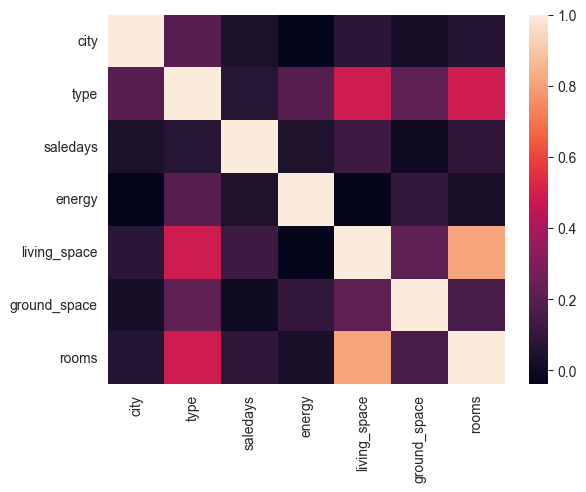

In [24]:
## Heat map
XcorrHeat = sns.heatmap(X.corr())
fig = XcorrHeat.get_figure()
plt.savefig('../EXAM/figs/Xvar_corr_heat_map_cat.png', bbox_inches='tight')

In [25]:
## Main model
param = {
    'random_state': seed,
    # Categorical
    'categorical_features':categorical_names
}
gradient_booster = HistGradientBoostingRegressor(**param)
# Gradient boosting classifiers are required to implement gradient boosting.
gradient_booster.fit(X_train,y_train)
y_test_predict_0de = gradient_booster.predict(X_test)

In [26]:
## R-squared
r2_HGBM = r2_score(y_test,y_test_predict_0de)
r2_HGBM

0.40584169119636393

In [27]:
## RMSE
RMSE_HGBM = mse(y_test,y_test_predict_0de,squared=False)
RMSE_HGBM

2404416.650567184

In [28]:
## Define hyperpara
param_grid = {
    # Tree param
    'max_depth': [1, 2, 3, 4],
    'min_samples_leaf': list(range(10,100,20)),
    # Boost param
    'learning_rate': [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6],
    # Miscellaneous param
    'random_state':seed,
    # Categorical
    'categorical_features':categorical_names
}


In [29]:
## 10-fold cross validation
num_folds = 10
kfolds = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

best_score = float('-inf')
best_params = {}

for min_samples_leaf in param_grid['min_samples_leaf']:
    for max_depth in param_grid['max_depth']:
        for learning_rate in param_grid['learning_rate']:
            params = {
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                # Boost param
                'learning_rate': learning_rate,
                # Miscellaneous param
                'random_state':seed,
                # Categorical
                'categorical_features':categorical_names
            }

        
        model = HistGradientBoostingRegressor(**params)
        scores = cross_val_score(model, X_train, y_train, cv=kfolds, scoring='neg_mean_squared_error')
        avg_score = np.mean(scores)
        
        if avg_score > best_score:
            best_score = avg_score
            best_params = params

print('Best Parameters:', best_params)
print('Best Score:', np.sqrt(-best_score))  # Convert back to positive mean squared error

# Fitting the model with best para
final_model = HistGradientBoostingRegressor(**best_params)
final_model.fit(X_train, y_train)

y_test_predict = final_model.predict(X_test)

Best Parameters: {'max_depth': 2, 'min_samples_leaf': 70, 'learning_rate': 1.6, 'random_state': 17082023, 'categorical_features': ['city', 'type', 'energy']}
Best Score: 2681554.018067692


In [30]:
## R-squared
r2_HGBM = r2_score(y_test,y_test_predict)
r2_HGBM

0.3014877191505274

In [31]:
## RMSE
RMSE_HGBM = mse(y_test,y_test_predict,squared=False)
RMSE_HGBM

2607027.8009256725

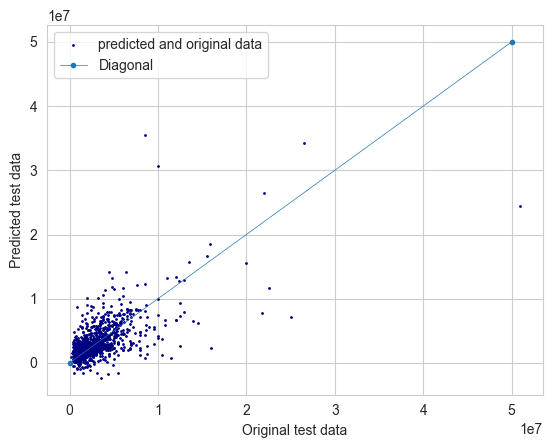

In [32]:
## plotting predicted data against real data

plt.scatter(y_test,y_test_predict, s= 1,c='navy',label='predicted and original data')
plt.plot([0,50000000],[0,50000000], linewidth=0.5,marker='.',label='Diagonal')
plt.xlabel('Original test data')
plt.ylabel('Predicted test data')
plt.legend()
plt.savefig('../EXAM/figs/HGBM_ori_vs_pred_cat',bbox_inches='tight')
plt.show()